<h1><center>Deep Learning Helping Navigate Robots - Baseline</center></h1>
<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/13242/logos/thumb76_76.png?t=2019-03-12-23-33-31" width="300"></img>

### Dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(0)

### Load data

In [2]:
train = pd.read_csv('../input/X_train.csv')
labels = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv')

print('Train features shape', train.shape)
print('Train labels shape', labels.shape)
print('Test shape', test.shape)

Train features shape (487680, 13)
Train labels shape (3810, 3)
Test shape (488448, 13)


### Join train features with labels

In [3]:
train = train.join(labels, on='series_id', rsuffix='_')
train.drop('series_id_', axis=1, inplace=True)

In [4]:
print('-----Train set-----')
print(train.shape)
display(train.describe().T)

-----Train set-----
(487680, 15)


,count,mean,std,min,25%,50%,75%,max
series_id,487680.0,1904.500000,1099.853353,0.00000,952.000000,1904.500000,2857.000000,3809.00000
measurement_number,487680.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,487680.0,-0.018050,0.685696,-0.98910,-0.705120,-0.105960,0.651803,0.98910
orientation_Y,487680.0,0.075062,0.708226,-0.98965,-0.688980,0.237855,0.809550,0.98898
orientation_Z,487680.0,0.012458,0.105972,-0.16283,-0.089466,0.031949,0.122870,0.15571
orientation_W,487680.0,-0.003804,0.104299,-0.15662,-0.106060,-0.018704,0.097215,0.15477
angular_velocity_X,487680.0,0.000178,0.117764,-2.37100,-0.040752,0.000084,0.040527,2.28220
angular_velocity_Y,487680.0,0.008338,0.088677,-0.92786,-0.033191,0.005412,0.048068,1.07910
angular_velocity_Z,487680.0,-0.019184,0.229153,-1.26880,-0.090743,-0.005335,0.064604,1.38730
linear_acceleration_X,487680.0,0.129281,1.870600,-36.06700,-0.530833,0.124980,0.792263,36.79700


In [5]:
print('-----Test set-----')
print(test.shape)
display(test.describe().T)

-----Test set-----
(488448, 13)


,count,mean,std,min,25%,50%,75%,max
series_id,488448.0,1907.500000,1101.585403,0.00000,953.750000,1907.500000,2861.250000,3815.00000
measurement_number,488448.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,488448.0,0.031996,0.671977,-0.98972,-0.648130,0.132910,0.575270,0.98932
orientation_Y,488448.0,0.120651,0.714522,-0.98981,-0.744503,0.397860,0.803600,0.98894
orientation_Z,488448.0,0.018735,0.108481,-0.15468,-0.112660,0.057271,0.124770,0.15425
orientation_W,488448.0,0.004024,0.100957,-0.15627,-0.098435,0.022654,0.083706,0.15251
angular_velocity_X,488448.0,0.000401,0.114485,-2.40330,-0.037396,0.001107,0.037827,3.39660
angular_velocity_Y,488448.0,0.013669,0.089440,-1.19300,-0.029865,0.007276,0.051112,1.15070
angular_velocity_Z,488448.0,-0.036101,0.233791,-1.45820,-0.089842,-0.008911,0.057876,0.96028
linear_acceleration_X,488448.0,0.125433,1.832639,-35.04000,-0.486233,0.112490,0.727250,36.62800


# EDA

## Label distribution
- Let's see what's the label distribution of our data

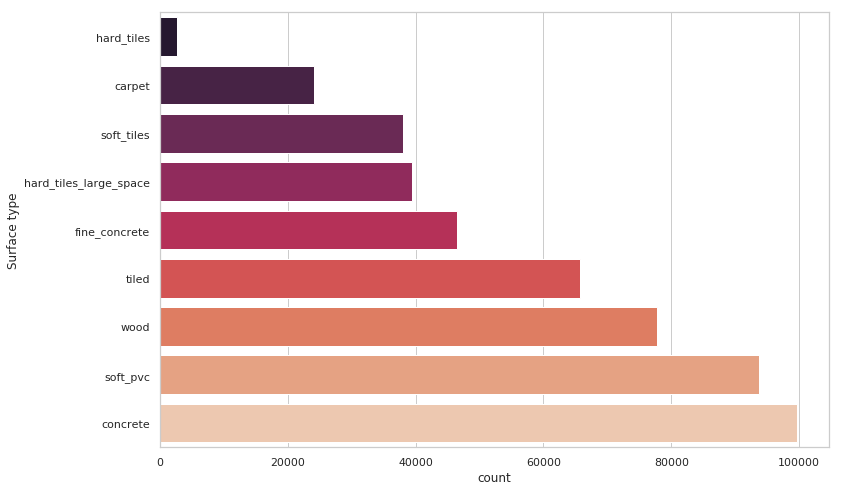

In [6]:
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(y='surface', data=train, palette="rocket", order=reversed(train['surface'].value_counts().index))
ax.set_ylabel("Surface type")
plt.show()

### Surface distribution by "group_id"

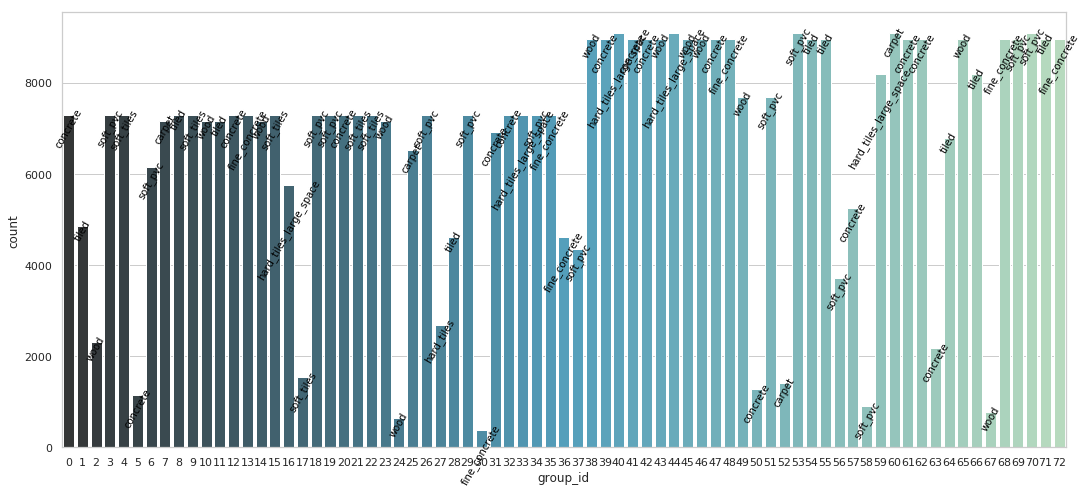

In [7]:
group_df = train.groupby(['group_id', 'surface'])['surface'].agg({'surface':['count']}).reset_index()
group_df.columns = ['group_id', 'surface', 'count']
f, ax = plt.subplots(figsize=(18, 8))
ax = sns.barplot(x="group_id", y="count", data=group_df, palette="GnBu_d")

for index, row in group_df.iterrows():
    ax.text(row.name, row['count'], row['surface'], color='black', ha="center", rotation=60)
    
plt.show()

## Features distribution
- Now would be a good idea to see how each other type of features behavior

### Orientation distribution

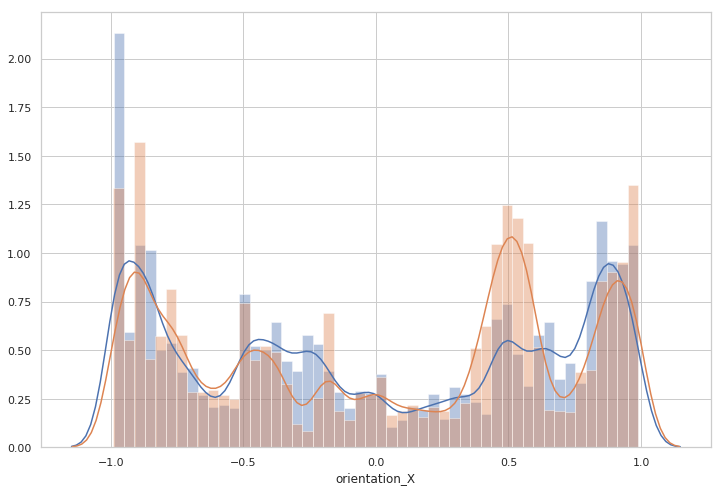

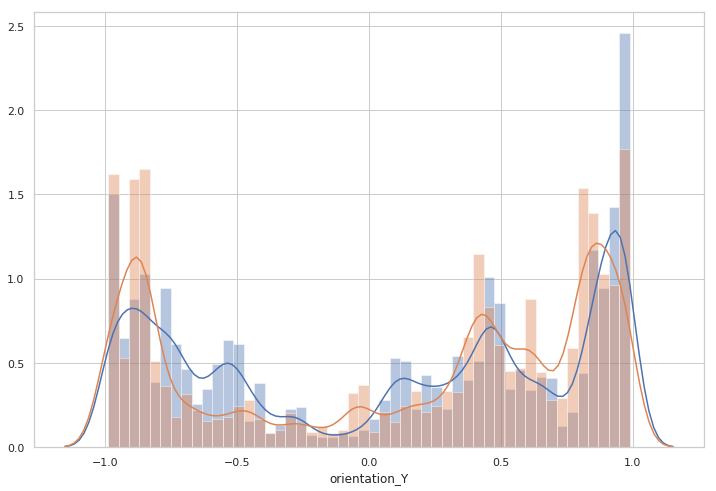

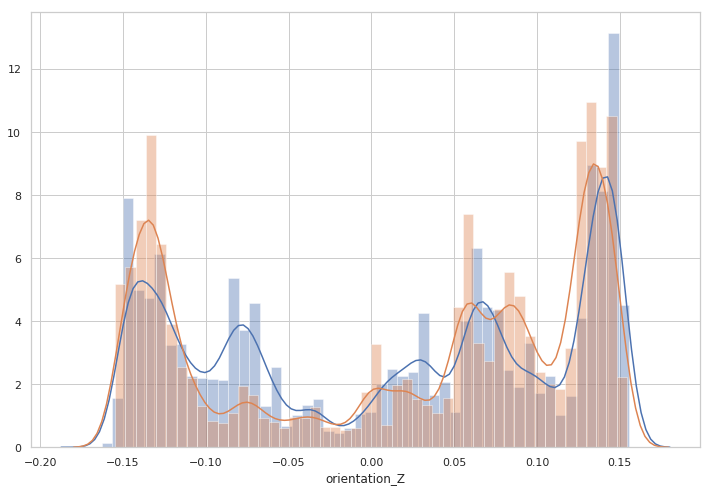

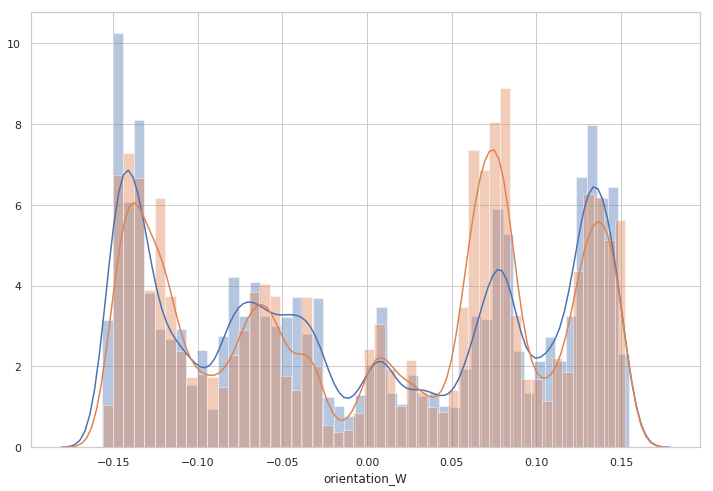

In [8]:
orientation_features = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W']
for feature in orientation_features:
    f, ax = plt.subplots(figsize=(12, 8))
    sns.distplot(train[feature])
    sns.distplot(test[feature])
    plt.show()

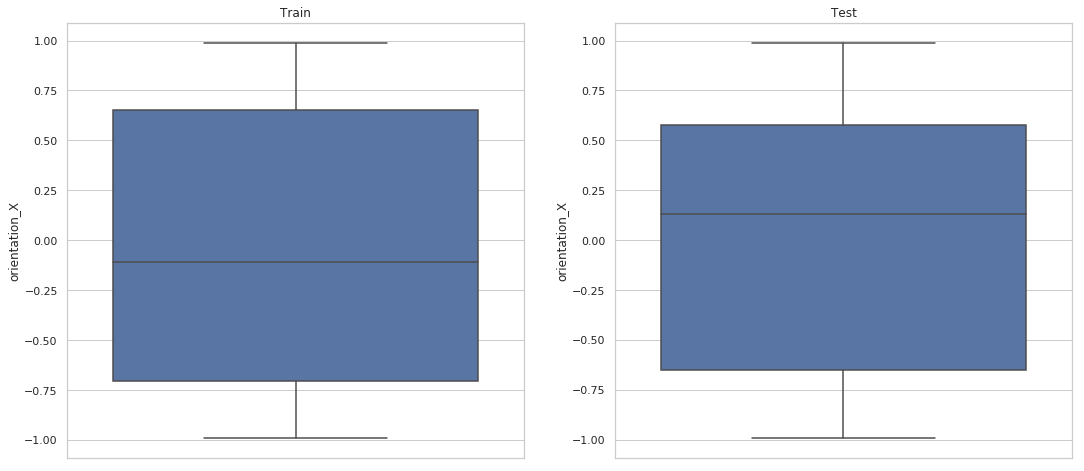

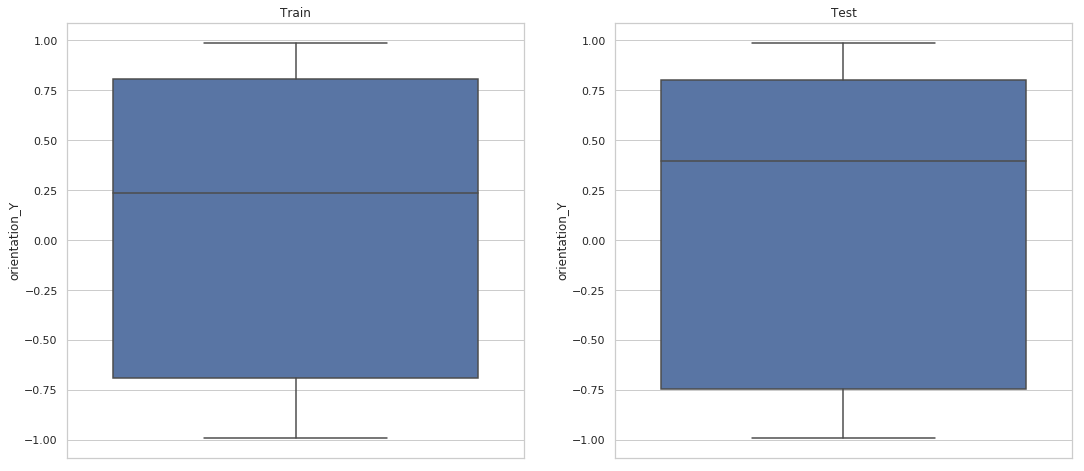

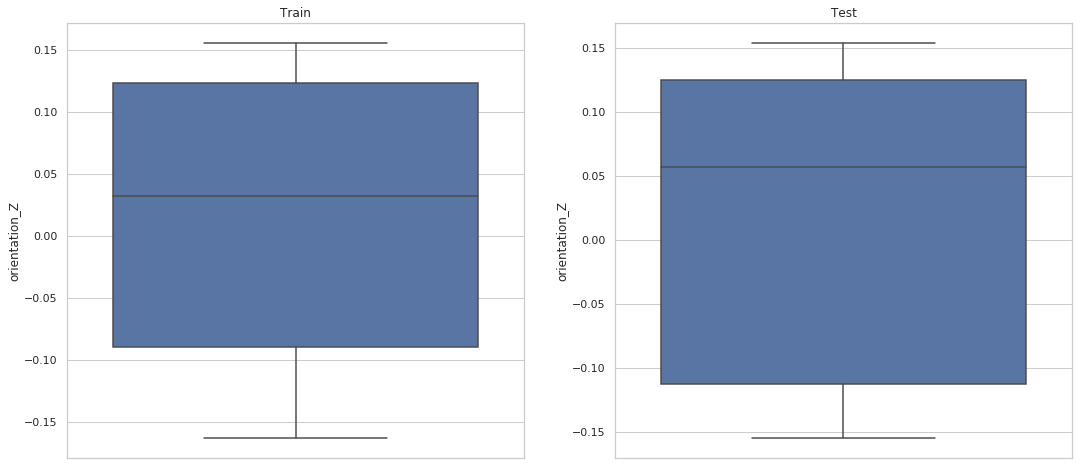

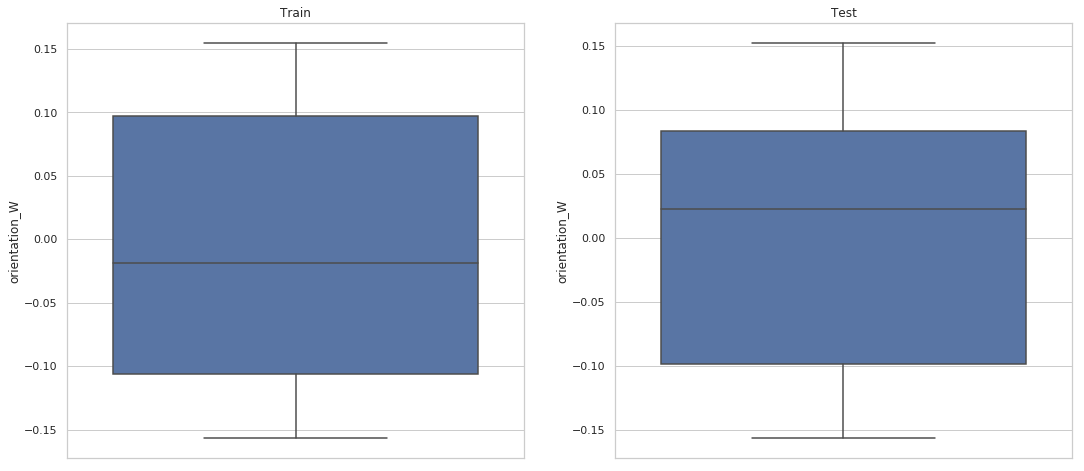

In [9]:
for feature in orientation_features:
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    sns.boxplot(y=train[feature], ax=axes[0]).set_title('Train')
    sns.boxplot(y=test[feature], ax=axes[1]).set_title('Test')
    plt.show()

The interesting part here is that "orientation_Y" and "orientation_X" are far more spread than the other two.

### Angular velocity distribution

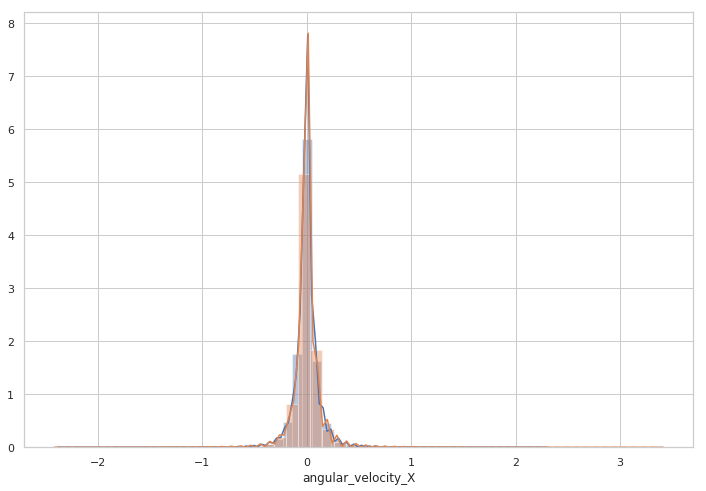

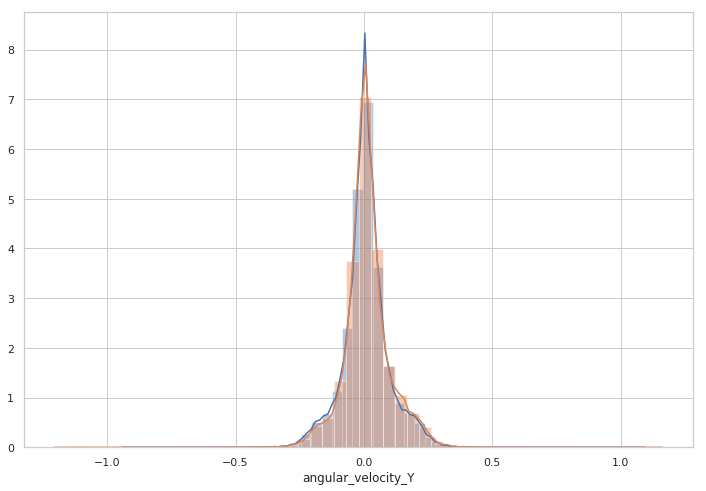

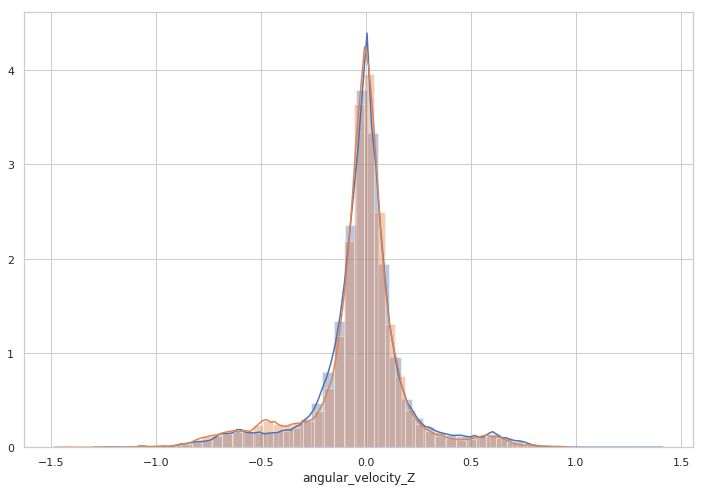

In [10]:
velocity_features = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']
for feature in velocity_features:
    f, ax = plt.subplots(figsize=(12, 8))
    sns.distplot(train[feature])
    sns.distplot(test[feature])
    plt.show()

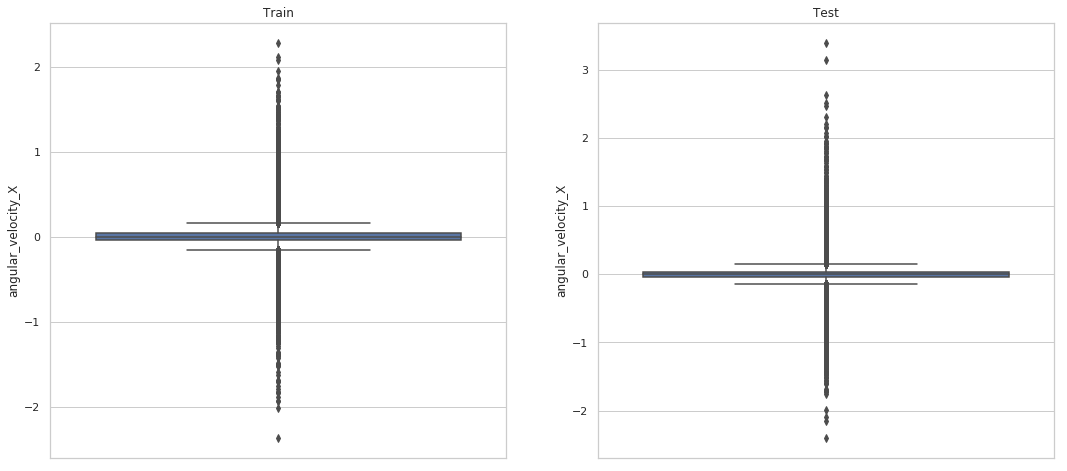

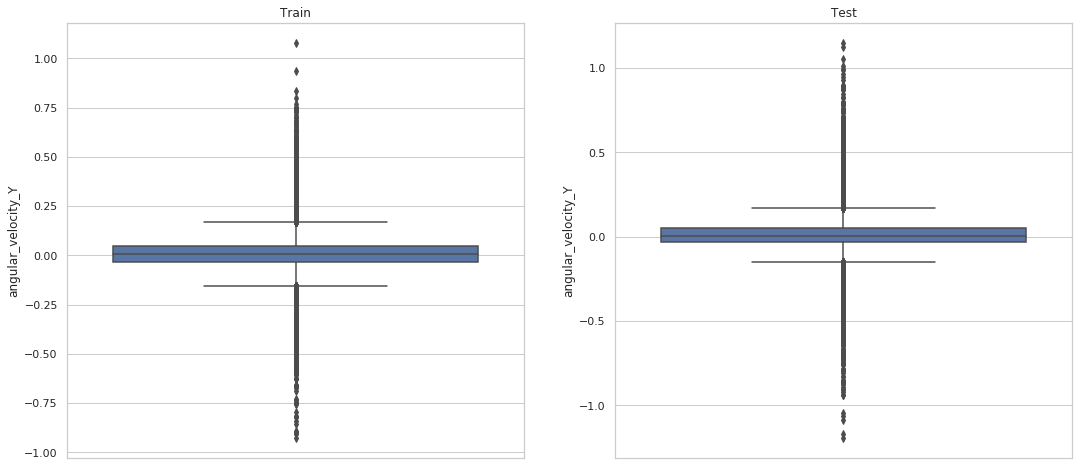

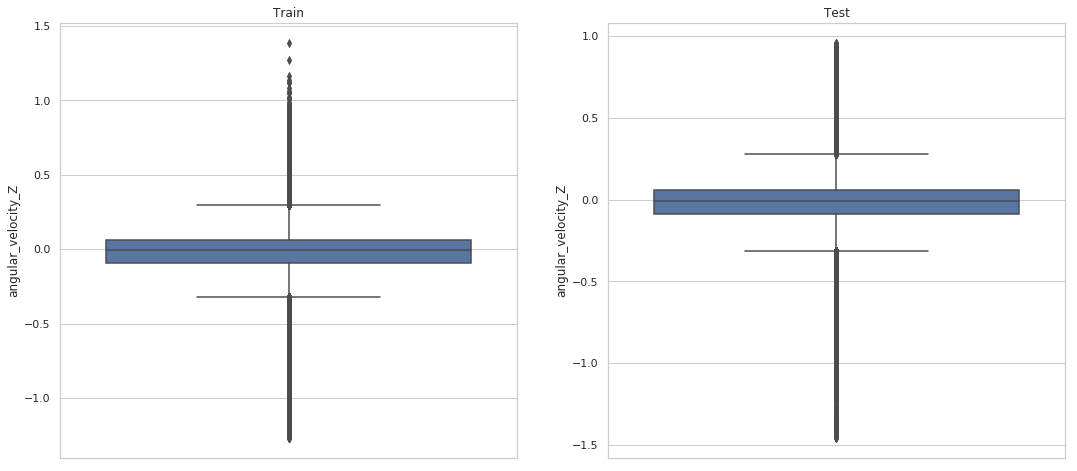

In [11]:
for feature in velocity_features:
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    sns.boxplot(y=train[feature], ax=axes[0]).set_title('Train')
    sns.boxplot(y=test[feature], ax=axes[1]).set_title('Test')
    plt.show()

Here all the angular velocity features seem to be centered around 0, but "angular_velocity_Y" is less spread than the others.

### Linear acceleration distribution

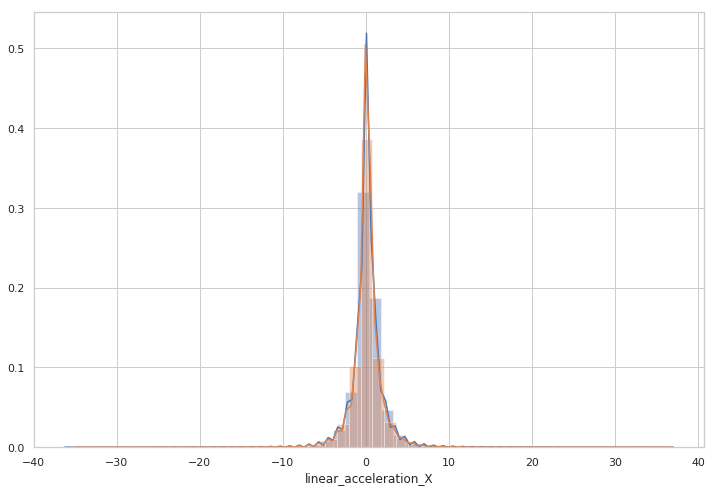

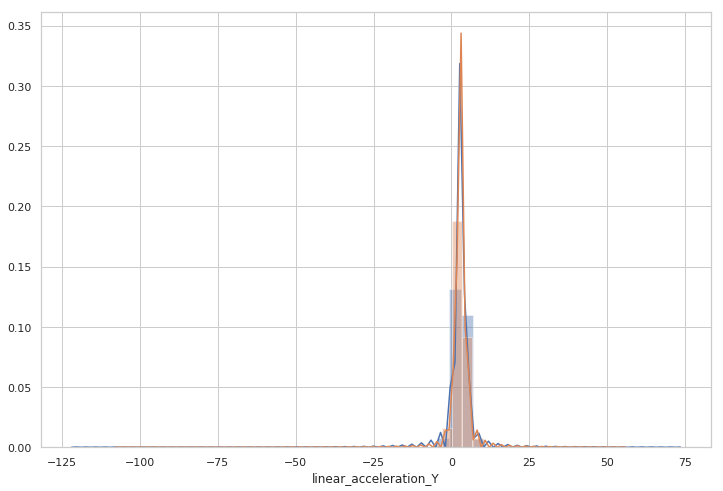

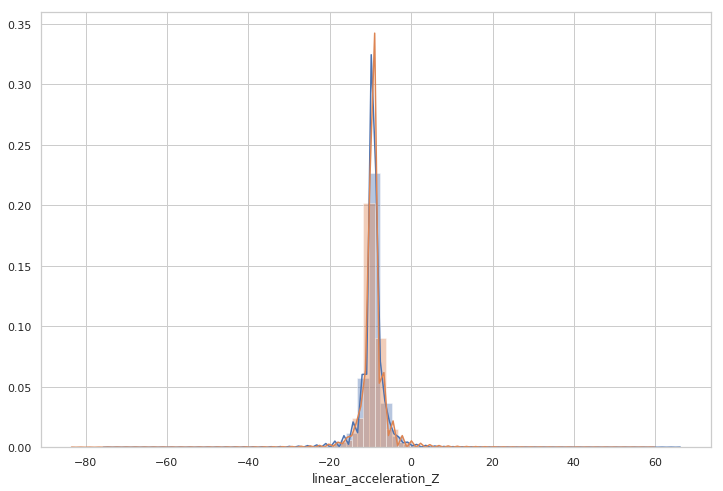

In [12]:
acceleration_features = ['linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']
for feature in acceleration_features:
    f, ax = plt.subplots(figsize=(12, 8))
    sns.distplot(train[feature])
    sns.distplot(test[feature])
    plt.show()

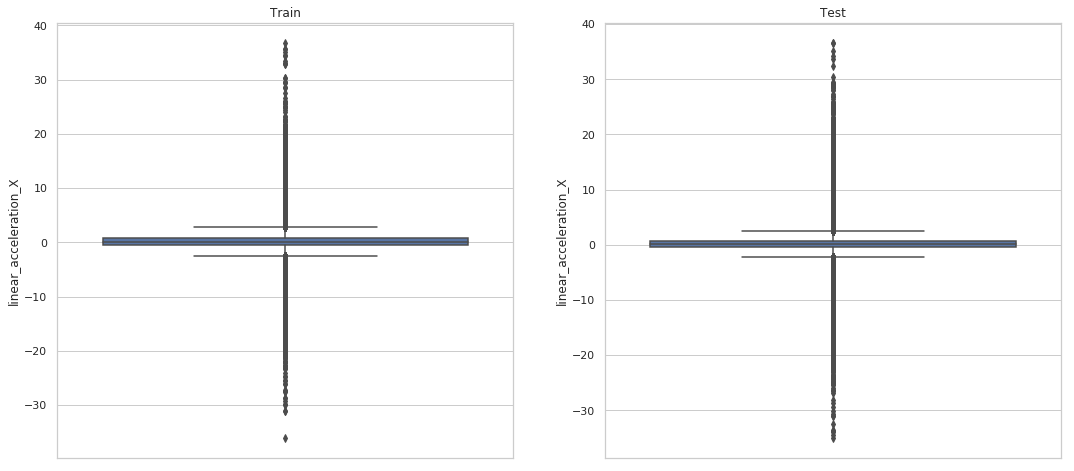

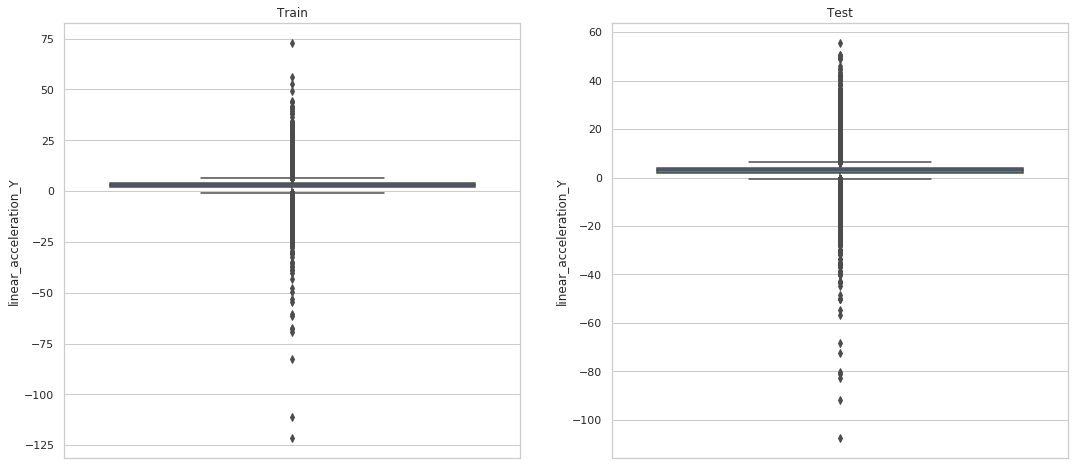

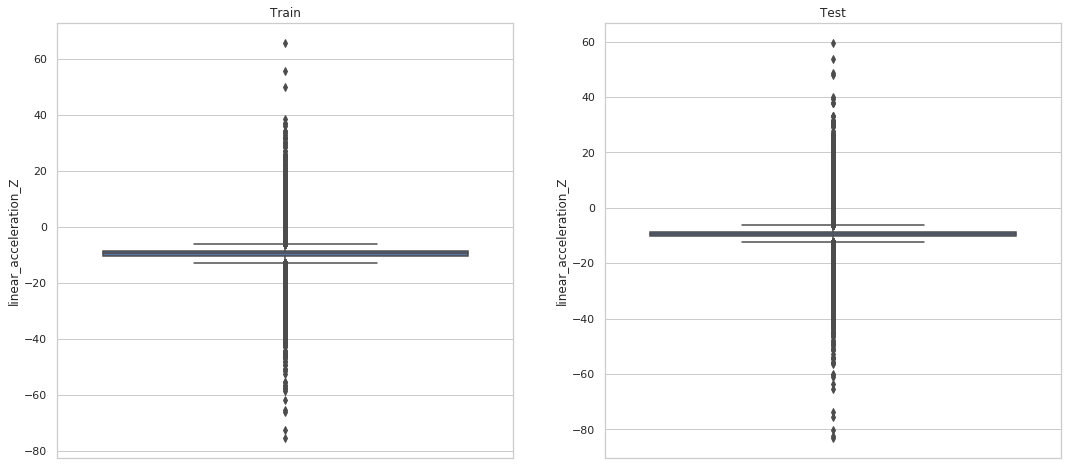

In [13]:
for feature in acceleration_features:
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    sns.boxplot(y=train[feature], ax=axes[0]).set_title('Train')
    sns.boxplot(y=test[feature], ax=axes[1]).set_title('Test')
    plt.show()

The linear acceleration features seem to be the most different between itself, all 3 features have different mean and spread.

### Preprocess the labels

In [14]:
target = train['surface']
n_labels = target.nunique()
labels_names = target.unique()
le = LabelEncoder()
target = le.fit_transform(target.values)
train.drop('surface', axis=1, inplace=True)

### Train/validation split

In [15]:
features = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 
            'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 
            'series_id', 'measurement_number']

X_train, X_val, Y_train, Y_val = train_test_split(train[features], target, test_size=0.2, random_state=0)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.head())

Train shape (390144, 12)
Validation shape (97536, 12)


,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id,measurement_number
174517,-0.22351,0.96262,0.147250,-0.041492,-0.023037,0.107670,-0.313830,0.016821,3.8752,-11.1430,1363,53
434895,-0.54943,-0.82225,-0.127320,-0.076376,0.356350,-0.165830,0.212980,1.202700,11.1940,-7.9759,3397,79
385247,0.78303,0.60372,0.097223,0.113750,0.064847,0.148310,-0.374690,-0.033998,2.8156,-10.2200,3009,95
374689,0.92600,0.34640,0.059994,0.137600,0.096735,-0.049043,0.144260,-0.457680,3.9749,-5.1218,2927,33
297812,-0.66945,-0.72716,-0.115300,-0.098892,0.215470,-0.010674,0.022843,1.427000,6.0013,-9.4340,2326,84


### Comparing validation and test sets

In [16]:
display(X_val.describe())
display(test[X_val.columns].describe())

,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id,measurement_number
count,97536.000000,97536.000000,97536.000000,97536.000000,97536.000000,97536.000000,97536.000000,97536.000000,97536.000000,97536.000000,97536.000000,97536.000000
mean,-0.018601,0.075580,0.012543,-0.003901,0.000590,0.008324,-0.019385,0.130933,2.883192,-9.368459,1906.435685,63.372150
std,0.685909,0.707958,0.105914,0.104331,0.118275,0.088666,0.228982,1.879506,2.110159,2.865567,1101.508251,36.867089
min,-0.989070,-0.989650,-0.162780,-0.156620,-2.371000,-0.817440,-1.267000,-36.067000,-49.706000,-55.532000,0.000000,0.000000
25%,-0.707350,-0.688825,-0.089345,-0.106552,-0.040407,-0.033284,-0.091265,-0.532580,1.953900,-10.198000,952.000000,31.000000
50%,-0.109775,0.238610,0.032101,-0.018933,0.000288,0.005480,-0.005929,0.128140,2.875150,-9.370000,1906.000000,63.000000
75%,0.651853,0.807670,0.122620,0.097283,0.040829,0.047849,0.063581,0.794320,3.796600,-8.521075,2863.000000,95.000000
max,0.989100,0.988970,0.155510,0.154730,1.659400,0.734880,1.387300,35.648000,55.948000,65.839000,3809.000000,127.000000


,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id,measurement_number
count,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000
mean,0.031996,0.120651,0.018735,0.004024,0.000401,0.013669,-0.036101,0.125433,2.906588,-9.359811,1907.500000,63.500000
std,0.671977,0.714522,0.108481,0.100957,0.114485,0.089440,0.233791,1.832639,2.094727,2.802670,1101.585403,36.949327
min,-0.989720,-0.989810,-0.154680,-0.156270,-2.403300,-1.193000,-1.458200,-35.040000,-107.480000,-83.173000,0.000000,0.000000
25%,-0.648130,-0.744503,-0.112660,-0.098435,-0.037396,-0.029865,-0.089842,-0.486233,2.052100,-10.125000,953.750000,31.750000
50%,0.132910,0.397860,0.057271,0.022654,0.001107,0.007276,-0.008911,0.112490,2.900300,-9.361700,1907.500000,63.500000
75%,0.575270,0.803600,0.124770,0.083706,0.037827,0.051112,0.057876,0.727250,3.758000,-8.582075,2861.250000,95.250000
max,0.989320,0.988940,0.154250,0.152510,3.396600,1.150700,0.960280,36.628000,55.624000,59.633000,3815.000000,127.000000


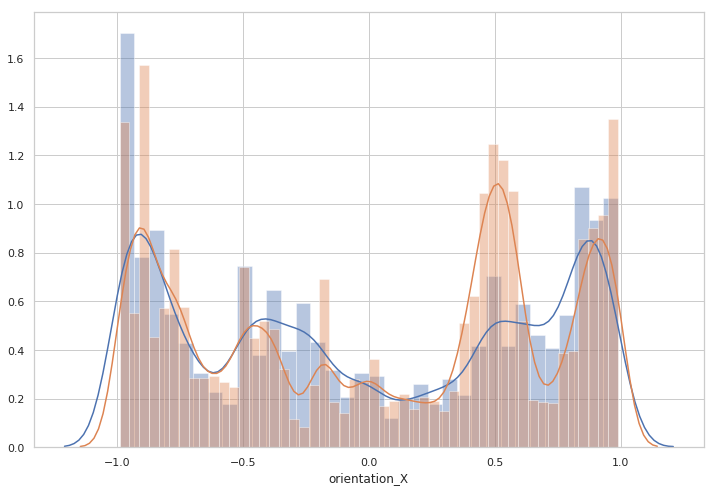

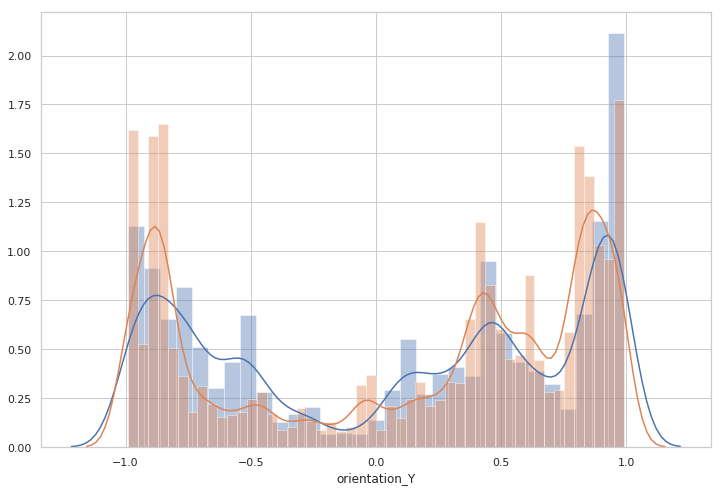

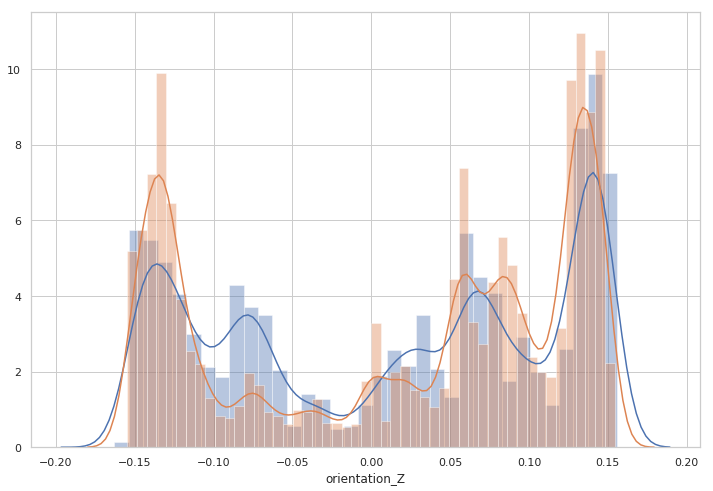

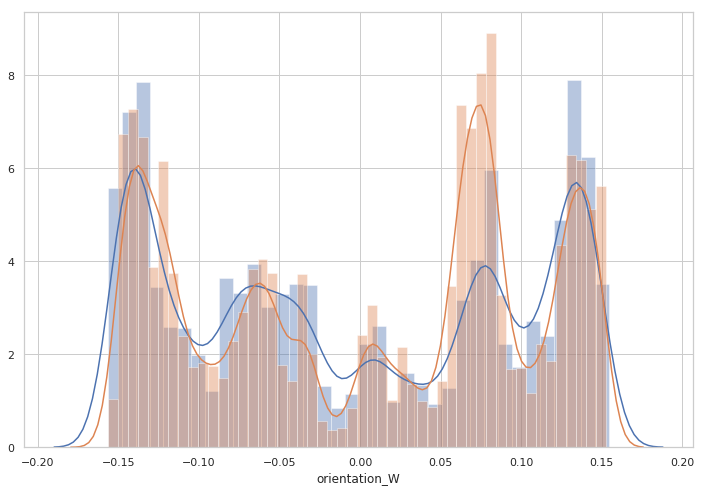

In [17]:
for feature in orientation_features:
    f, ax = plt.subplots(figsize=(12, 8))
    sns.distplot(X_val[feature])
    sns.distplot(test[feature])
    plt.show()

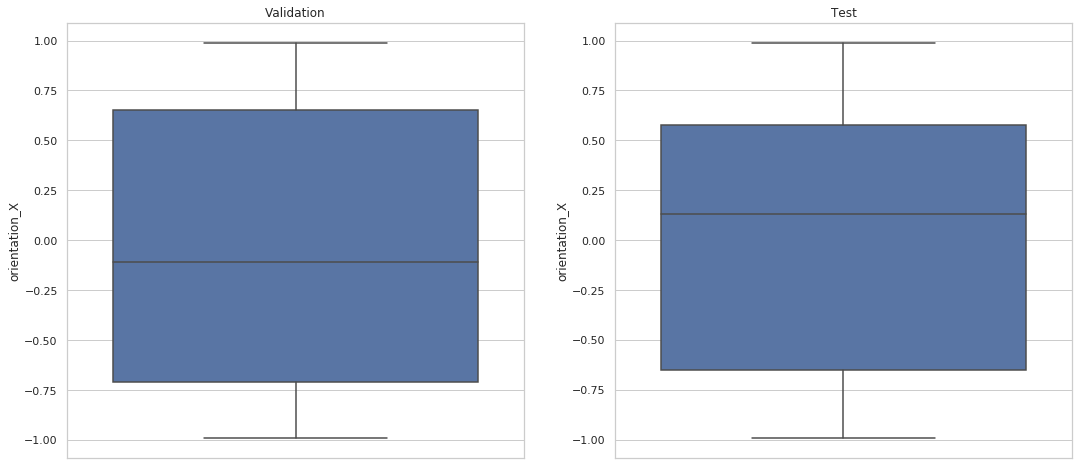

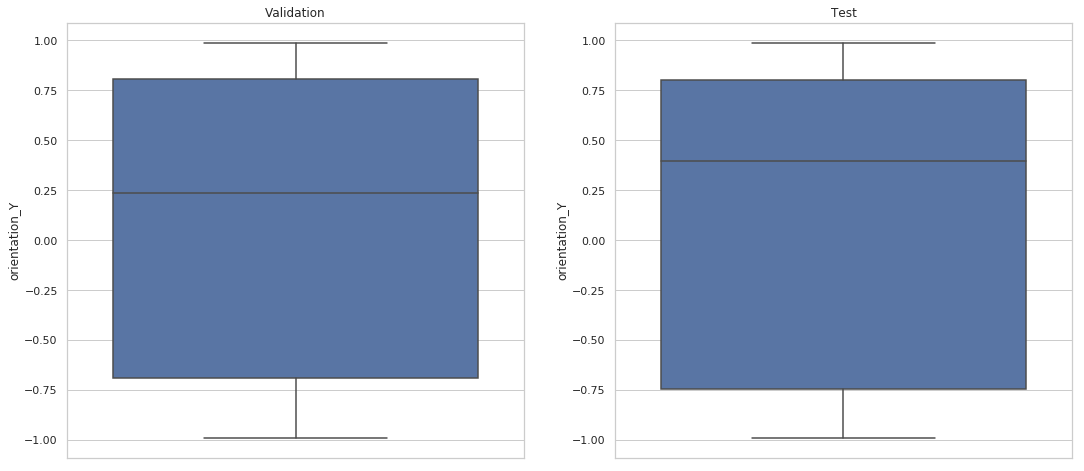

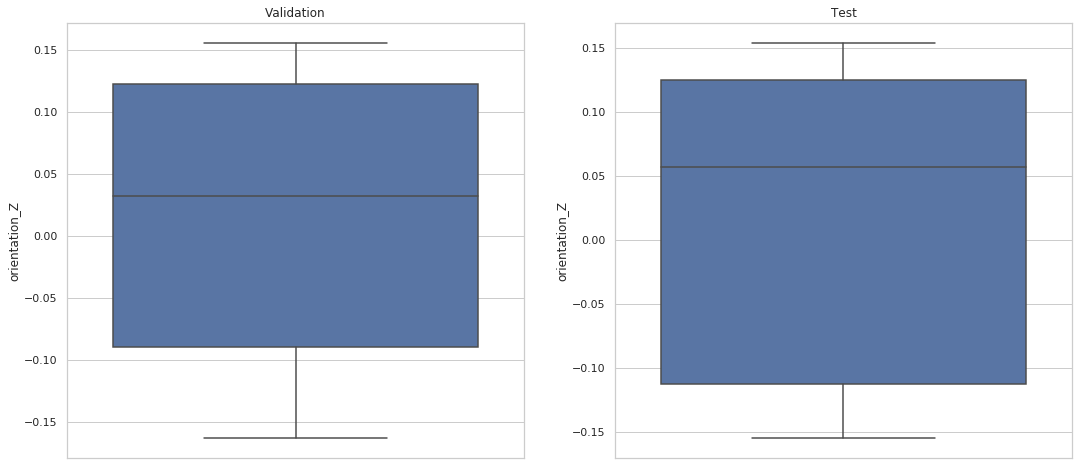

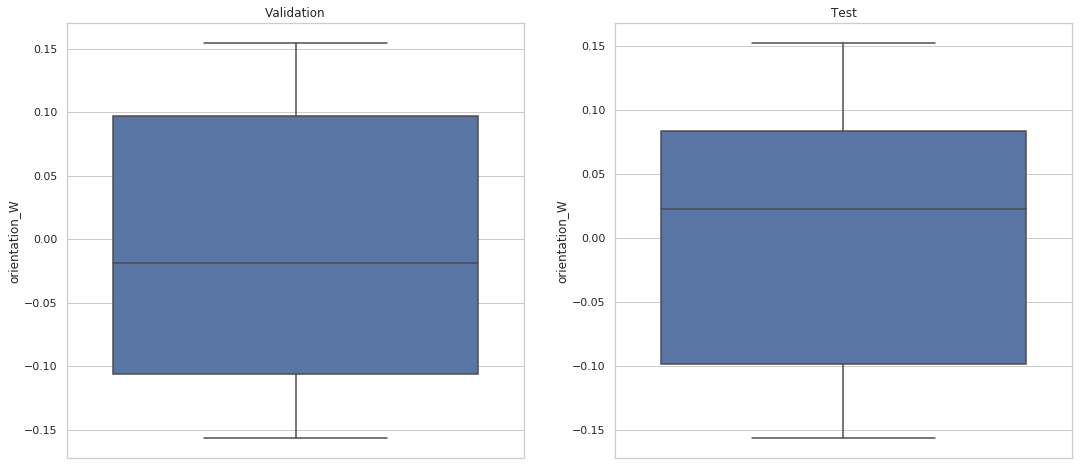

In [18]:
for feature in orientation_features:
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    sns.boxplot(y=X_val[feature], ax=axes[0]).set_title('Validation')
    sns.boxplot(y=test[feature], ax=axes[1]).set_title('Test')
    plt.show()

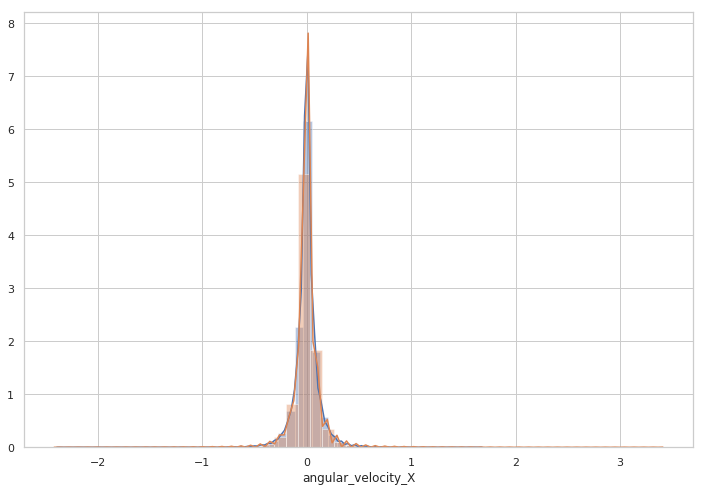

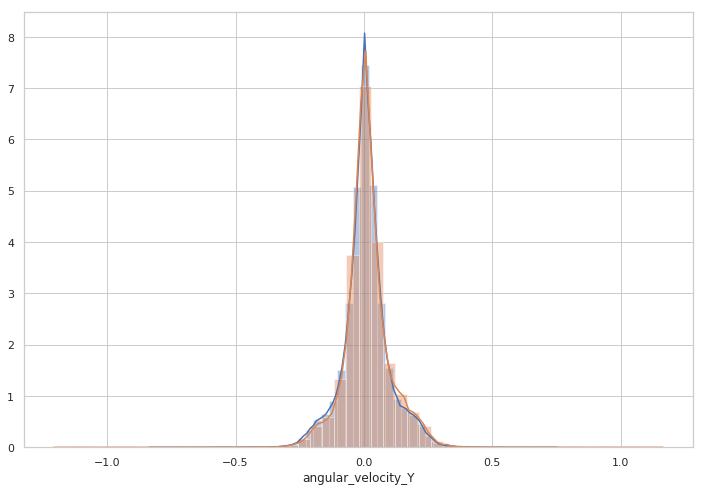

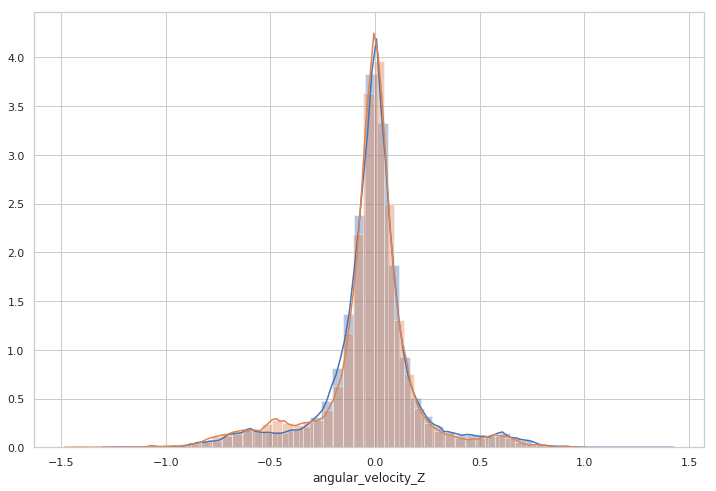

In [19]:
for feature in velocity_features:
    f, ax = plt.subplots(figsize=(12, 8))
    sns.distplot(X_val[feature])
    sns.distplot(test[feature])
    plt.show()

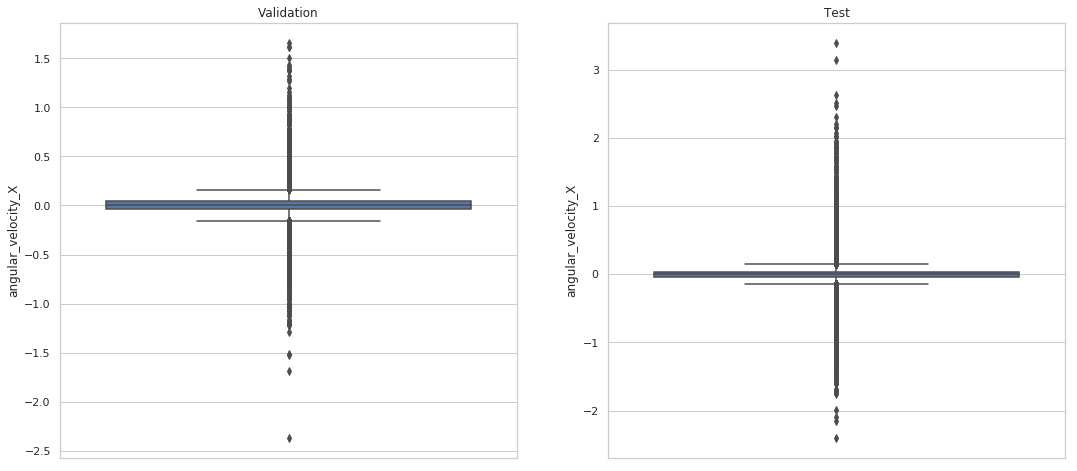

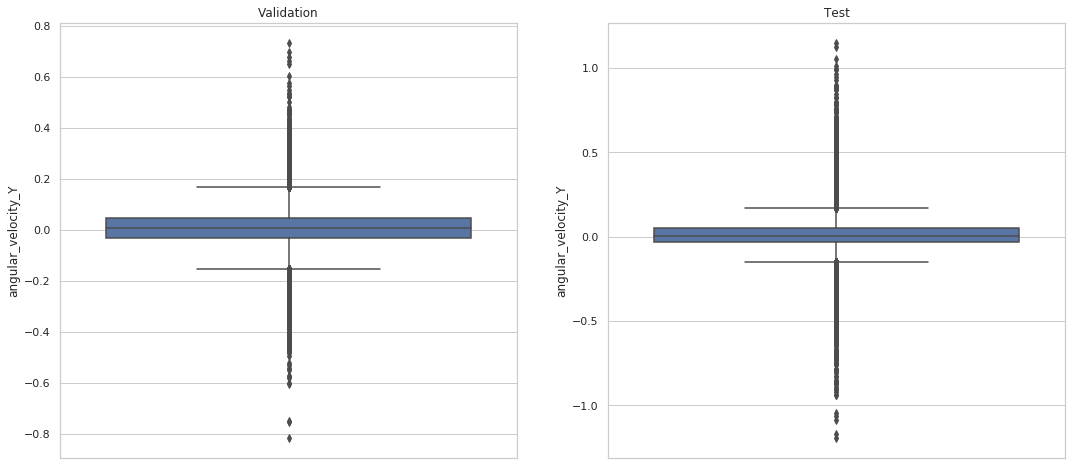

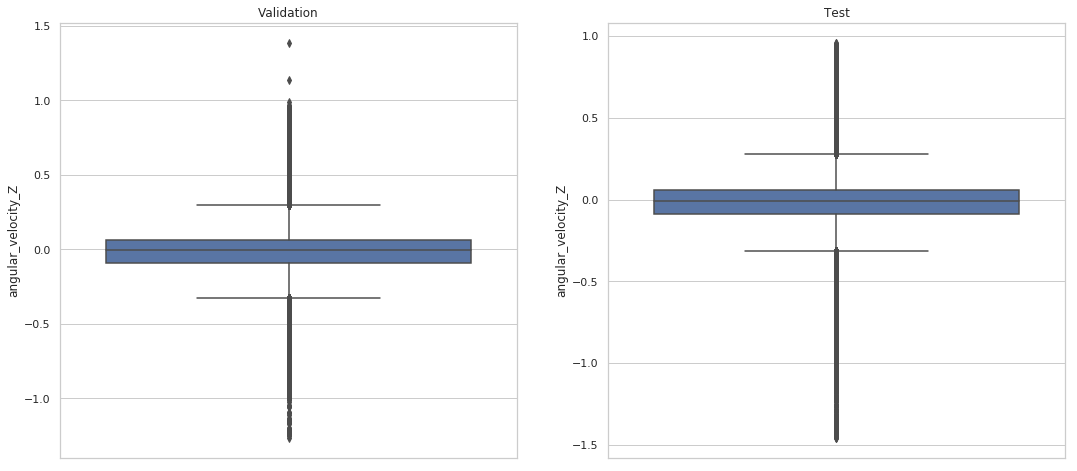

In [20]:
for feature in velocity_features:
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    sns.boxplot(y=X_val[feature], ax=axes[0]).set_title('Validation')
    sns.boxplot(y=test[feature], ax=axes[1]).set_title('Test')
    plt.show()

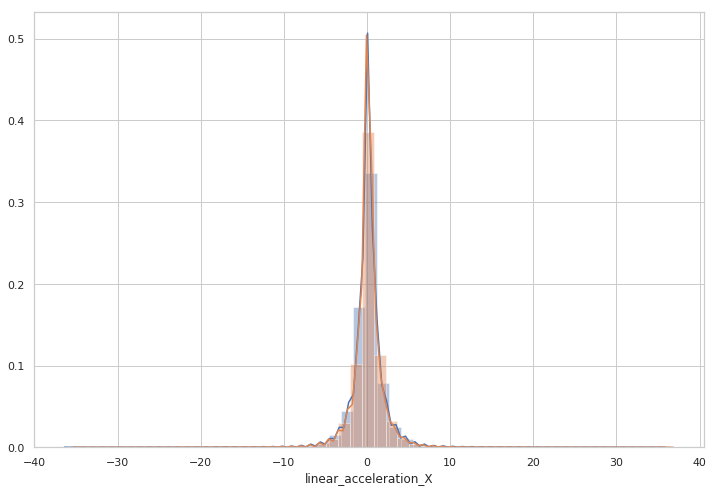

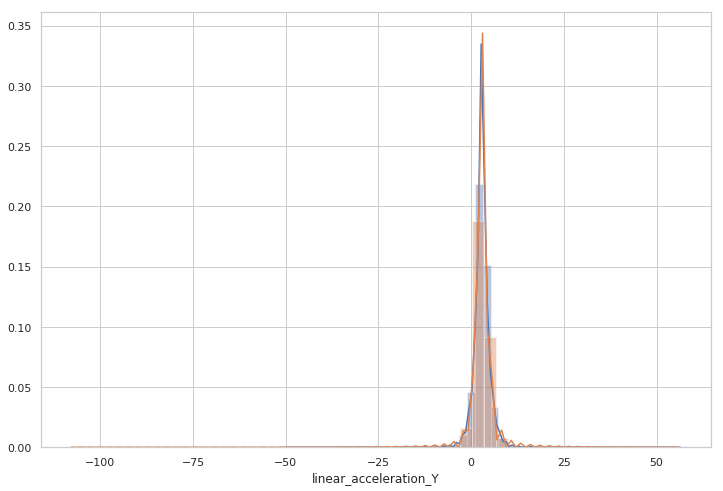

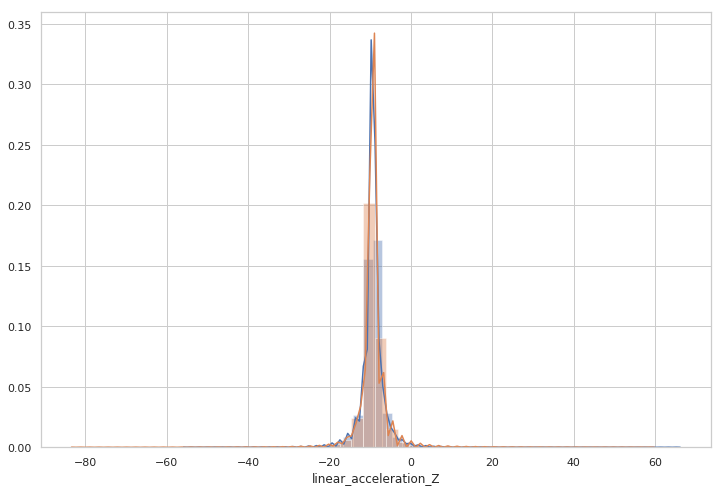

In [21]:
for feature in acceleration_features:
    f, ax = plt.subplots(figsize=(12, 8))
    sns.distplot(X_val[feature])
    sns.distplot(test[feature])
    plt.show()

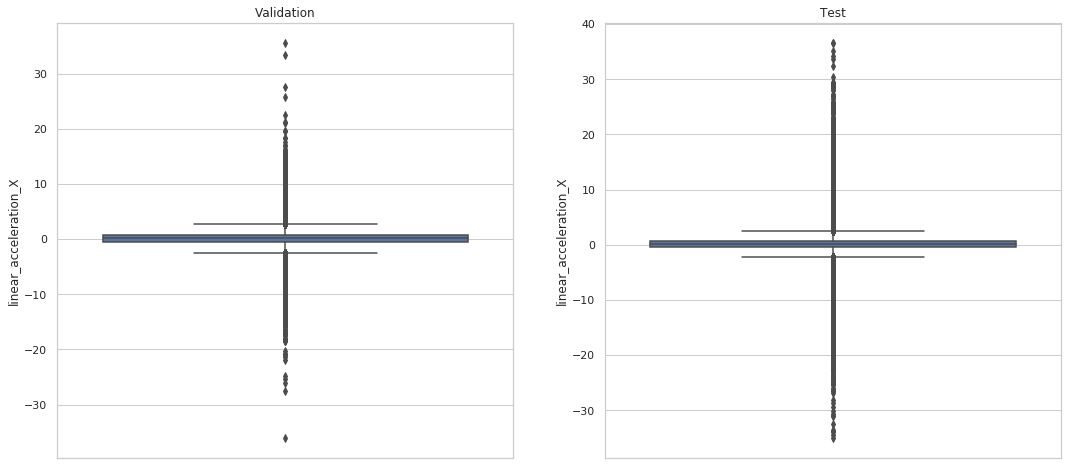

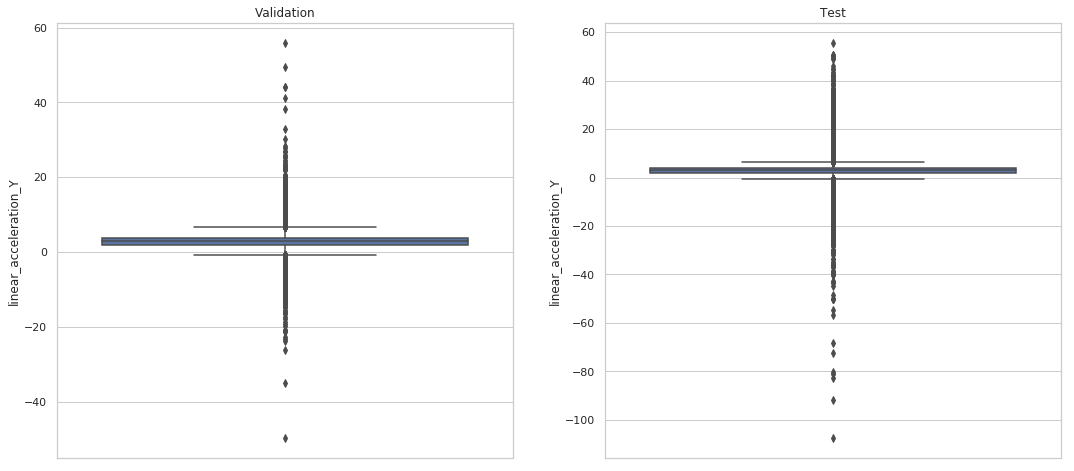

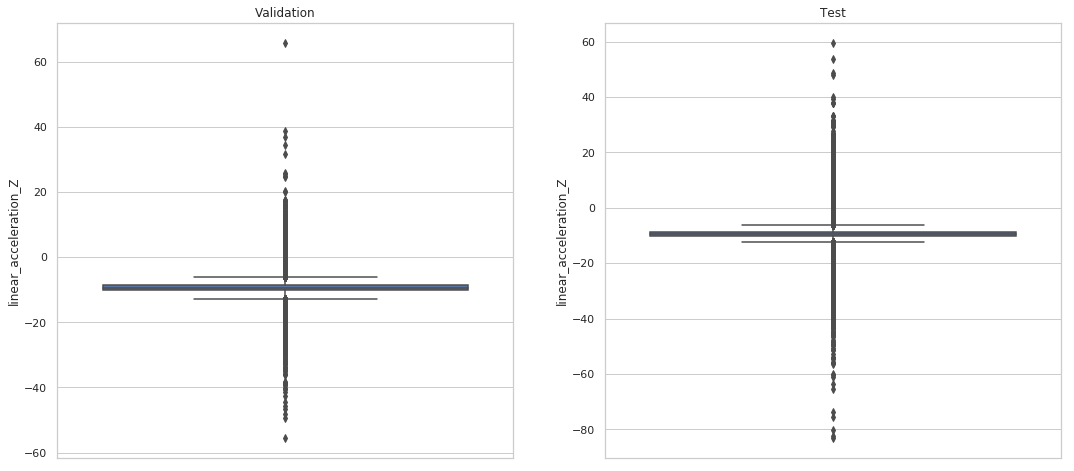

In [22]:
for feature in acceleration_features:
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    sns.boxplot(y=X_val[feature], ax=axes[0]).set_title('Validation')
    sns.boxplot(y=test[feature], ax=axes[1]).set_title('Test')
    plt.show()